<a href="https://colab.research.google.com/github/josbex/D0021E_Labs/blob/master/Hate_speech_detection_in_social_media_posts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Hate Speech detection in social media posts

##Neccessary imports

In [1]:
import tensorflow as tf
import torch
import pandas as  pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import time
import datetime
import collections
import random
from sklearn.metrics import f1_score, confusion_matrix
import csv
import os

## Using GPU for training BERT model

Go to: Edit -> Notebook settinngs -> Hardware accelerator -> (GPU)

In [3]:
# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')


Found GPU at: /device:GPU:0


In [4]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


## Dataset

The dataset needs to be loaded from the drive (this entails the dataset is in your drive). If so, just run the cell below and follow the link to get an authorization code. 

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [6]:
def get_dataset(filename):
  df = pd.read_csv("/content/gdrive/My Drive/thesis/dataset/" + filename +".tsv", sep="\t") 
  #Saving tweets and their labels as numpy arrays
  tweets = df.tweet.values
  labels = df.label.values
  return tweets, labels

##Save fine-tuned model

In [45]:
def save_model(model):
  # Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()
  output_dir = './model_save/'

  # Create output directory if needed
  if not os.path.exists(output_dir):
      os.makedirs(output_dir)

  print("Saving model to %s" % output_dir)

  # Save a trained model, configuration and tokenizer using `save_pretrained()`.
  # They can then be reloaded using `from_pretrained()`
  model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
  model_to_save.save_pretrained(output_dir)
  tokenizer.save_pretrained(output_dir)

  # Copy the model files to a directory in your Google Drive.
  !cp -r ./model_save/ "./gdrive/My Drive/thesis/model/learn_rate_3"

##Load saved model

In [40]:
# Load a trained model and vocabulary that you have fine-tuned
#TODO: specify folder to be able to load different models
def load_model():
  #Directory of best model so far
  #output_dir = "./gdrive/My Drive/thesis/model/learn_rate_5/model_save"
  #previously best model
  output_dir = "./gdrive/My Drive/thesis/model/model_save"
  #Directory of second round of training
  #output_dir = "./gdrive/My Drive/thesis/model/second_training/model_save"
  model = BertForSequenceClassification.from_pretrained(output_dir)
  tokenizer = BertTokenizer.from_pretrained(output_dir)
  # Copy the model to the GPU.
  model.to(device)
  return model, tokenizer

##Helper functions for testing the model

In [9]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
  #Get the highest predicions per tweet, and turn the result into a 1d list 
  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  #sum up element-wise comparisons to calculate the average accuracy
  return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [10]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [47]:
def prepare_test_data(batch_size, tokenizer):
  tweets, labels = get_dataset('test_data')
  print("len tweets:" , len(tweets))
  print("len labels:" , len(labels))

  # Tokenize all of the sentences and map the tokens to thier word IDs.
  input_ids = []
  attention_masks = []

  # For every sentence...
  for tweet in tweets:
      # `encode_plus` will:
      #   (1) Tokenize the sentence.
      #   (2) Prepend the `[CLS]` token to the start.
      #   (3) Append the `[SEP]` token to the end.
      #   (4) Map tokens to their IDs.
      #   (5) Pad or truncate the sentence to `max_length`
      #   (6) Create attention masks for [PAD] tokens.
      encoded_dict = tokenizer.encode_plus(
                          tweet,                      # Sentence to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          truncation=True,
                          max_length = 152,           # Pad & truncate all sentences. #used to be 152
                          pad_to_max_length = True,
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                    )
      
      # Add the encoded sentence to the list.    
      input_ids.append(encoded_dict['input_ids'])
      
      # And its attention mask (simply differentiates padding from non-padding).
      attention_masks.append(encoded_dict['attention_mask'])

  # Convert the lists into tensors.
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)

  # Set the batch size.  
  batch_size = batch_size  

  # Create the DataLoader.
  prediction_data = TensorDataset(input_ids, attention_masks, labels)
  prediction_sampler = SequentialSampler(prediction_data)
  prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)
  return prediction_dataloader, len(tweets)

In [12]:
def test(batch_size, model, tokenizer):
  prediction_dataloader, nrOfTweets = prepare_test_data(batch_size, tokenizer)
  test_total_accuracy = 0
  test_total_f1_score = 0

  print('Predicting labels for {:,} test tweets...'.format(nrOfTweets))

  # Put model in evaluation mode
  model.eval()

  # Tracking variables 
  predictions , true_labels = [], []

  # Predict 
  for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # Telling the model not to compute or store gradients, saving memory and 
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, 
                        attention_mask=b_input_mask)

    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

  print('DONE.')
  return predictions, true_labels

In [13]:
def get_test_accuracy_and_f1_score(predictions, true_labels):
  # Combine the results across all batches. 
  flat_predictions = np.concatenate(predictions, axis=0)
  # Combine the correct labels for each batch into a single list.
  flat_true_labels = np.concatenate(true_labels, axis=0)
  test_accuracy = flat_accuracy(flat_predictions, flat_true_labels)
  # For each sample, pick the label (0 or 1) with the higher score.
  flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
  test_f1_score = f1_score(flat_true_labels, flat_predictions, average='macro')
  return test_accuracy, test_f1_score

def predictions_flattened(predictions):
  flat_predictions = np.concatenate(predictions, axis=0)
  flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
  return flat_predictions

def true_labels_flattened(true_labels):
  return np.concatenate(true_labels, axis=0)

## BERT Tokenization 



In [14]:
!pip install transformers

from transformers import BertTokenizer
# OPTIONAL: if you want to have more information on what's happening under the hood, activate the logger as follows
import logging
logging.basicConfig(level=logging.INFO)

     |████████████████████████████████| 778kB 3.5MB/s 
     |████████████████████████████████| 890kB 18.0MB/s 
     |████████████████████████████████| 3.0MB 24.3MB/s 
     |████████████████████████████████| 1.1MB 33.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=0e74e8da9e092cd621ca6f4a0b174182b62e2fee8f62d8cc8c9e33a01fc9d449
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [48]:
# Tokenize with BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

INFO:transformers.tokenization_utils_base:loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /root/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084


Guide on how to tokenize and turn the lists into tensors was found here: https://mccormickml.com/2019/07/22/BERT-fine-tuning/

In [49]:
def data_to_tensors(tweets, labels):
  # Tokenize all of the sentences and map the tokens to their word IDs.
  input_ids = []
  attention_masks = []
  # For every sentence...
  #for tweet in seperated_tweets:
  for tweet in tweets:
      # `encode_plus` will:
      #   (1) Tokenize the sentence.
      #   (2) Map tokens to their IDs.
      #   (3) Pad or truncate the sentence to `max_length`
      #   (4) Create attention masks for [PAD] tokens.
      encoded_dict = tokenizer.encode_plus(
                          tweet,                      # tweet to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'?
                          truncation=True,
                          max_length = 152,           # Pad & truncate all tweets. #Used to be 152
                          pad_to_max_length = True,
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                    )
      
      # Add the encoded sentence to the list.    
      input_ids.append(encoded_dict['input_ids'])

      # And its attention mask (simply differentiates padding from non-padding).
      attention_masks.append(encoded_dict['attention_mask'])

  # Convert the lists into tensors.
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)
  return input_ids, attention_masks, labels

### Attention Mask

Since each tweet needs to be of the same lenght they have been padded to be of the same lenght as the longest tweet. BERT will not need to pay attention to the padding, thus attention masks are neeeded for each tweet to distingush between real input and padding. See more: https://huggingface.co/transformers/glossary.html#attention-mask


### Split data into training and validation sets
The guide also found here: https://mccormickml.com/2019/07/22/BERT-fine-tuning/

Why it is good to have an validation set is because it is a good test to use for overfitting. Instead of just considering validation accuracy, validation loss can also be observed, which is basically a measurement of how confindent the model was on the correct prediction. 

In [17]:
from torch.utils.data import TensorDataset
# Combine the training inputs into a TensorDataset.
tweets, labels = get_dataset('90_training_data')
input_ids, attention_masks, labels = data_to_tensors(tweets, labels)
train_dataset = TensorDataset(input_ids, attention_masks, labels)

# Combine the validation inputs into a TensorDataset.
tweets, labels = get_dataset('10_val_data')
input_ids, attention_masks, labels = data_to_tensors(tweets, labels)
val_dataset = TensorDataset(input_ids, attention_masks, labels)

print('{:>5,} training samples'.format(len(train_dataset)))
print('{:>5,} validation samples'.format(len(val_dataset)))

11,916 training samples
1,324 validation samples


The guide also recommed to create an iterator for the dataset since this save on memory compared to using regular for loops. See more: https://pytorch.org/docs/stable/data.html

In [18]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
def create_dataloaders(batch_size):
  # The DataLoader needs to know our batch size for training, so we specify it 
  # here. For fine-tuning BERT on a specific task, the authors recommend a batch 
  # size of 16 or 32.
  batch_size = batch_size

  # Create the DataLoaders for our training and validation sets.
  # We'll take training samples in random order. 
  train_dataloader = DataLoader(
              train_dataset,  # The training samples.
              sampler = RandomSampler(train_dataset), # Select batches randomly
              batch_size = batch_size # Trains with this batch size.
          )

  # For validation the order doesn't matter, so we'll just read them sequentially.
  validation_dataloader = DataLoader(
              val_dataset, # The validation samples.
              sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
              batch_size = batch_size # Evaluate with this batch size.
          )
  return train_dataloader, validation_dataloader

###Linear schedule with warmup
Create a schedule with a learning rate that decreases linearly from the initial lr set in the optimizer to 0, after a warmup period during which it increases linearly from 0 to the initial lr set in the optimizer.

In [19]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
def setup_model(epoch, learn_rate, train_dataloader):
  # Load BertForSequenceClassification, the pretrained BERT model with a single 
  # linear classification layer on top. 
  model = BertForSequenceClassification.from_pretrained(
      "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
      num_labels = 2, # The number of output labels--2 for binary classification.   
      output_attentions = False, # Whether the model returns attentions weights.
      output_hidden_states = False, # Whether the model returns all hidden-states.
  )

  # Tell pytorch to run this model on the GPU.
  model.cuda()
  #The epsilon parameter eps = 1e-8 is “a very small number to prevent any division by zero in the implementation”
  optimizer = AdamW(model.parameters(),
                    lr = learn_rate, # args.learning_rate 
                    eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                  )
  # Number of training epochs. The BERT authors recommend between 2 and 4. 
  epochs = epoch

  # Total number of training steps is [number of batches] x [number of epochs]. 
  # (Note that this is not the same as the number of training samples).
  total_steps = len(train_dataloader) * epochs

  # Create the learning rate scheduler.
  scheduler = get_linear_schedule_with_warmup(optimizer, 
                                              num_warmup_steps = 0, # Default value in run_glue.py
                                              num_training_steps = total_steps)
  return model, optimizer, scheduler

##Training helper functions

In [20]:
#No point in keep training a model when the range between validation loss and training loss becomes to great
def stop_early(training_stats):
  if(abs(training_stats[len(training_stats)-1]['Valid. Loss'] - training_stats[len(training_stats)-1]['Training Loss']) > 0.2 and (len(training_stats) > 1)):
    return True
  else:
    return False

In [21]:
def train_and_validate(model, optimizer, scheduler, train_dataloader, validation_dataloader, epochs, batch_size):
  # This training code is based on the `run_glue.py` script here:
  # https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

  # Set the seed value all over the place to make this reproducible.
  seed_val = 42

  random.seed(seed_val)
  np.random.seed(seed_val)
  torch.manual_seed(seed_val)
  torch.cuda.manual_seed_all(seed_val)

  # We'll store a number of quantities such as training and validation loss, 
  # validation accuracy, and timings.
  training_stats = []
  mid_training_stats = []
  mid_validation_stats = []

  # Measure the total training time for the whole run.
  total_t0 = time.time()

  # For each epoch...
  for epoch_i in range(0, epochs):
      
      # ========================================
      #               Training
      # ========================================
      
      # Perform one full pass over the training set.

      print("")
      print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
      print('Training...')

      # Measure how long the training epoch takes.
      t0 = time.time()

      # Reset the total loss for this epoch.
      total_train_loss = 0

      # Put the model into training mode. Don't be mislead--the call to 
      # `train` just changes the *mode*, it doesn't *perform* the training.
      # `dropout` and `batchnorm` layers behave differently during training
      # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
      model.train()

      # For each batch of training data...
      for step, batch in enumerate(train_dataloader):

          # Progress update every 40 batches.
          if step % 40 == 0 and not step == 0:
              # Calculate elapsed time in minutes.
              elapsed = format_time(time.time() - t0)
              
              # Report progress.
              print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

          # Unpack this training batch from our dataloader. 
          #
          # As we unpack the batch, we'll also copy each tensor to the GPU using the 
          # `to` method.
          #
          # `batch` contains three pytorch tensors:
          #   [0]: input ids 
          #   [1]: attention masks
          #   [2]: labels 
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_labels = batch[2].to(device)

          # Always clear any previously calculated gradients before performing a
          # backward pass. PyTorch doesn't do this automatically because 
          # accumulating the gradients is "convenient while training RNNs". 
          # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
          model.zero_grad()        

          # Perform a forward pass (evaluate the model on this training batch).
          # The documentation for this `model` function is here: 
          # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
          # It returns different numbers of parameters depending on what arguments
          # arge given and what flags are set. For our useage here, it returns
          # the loss (because we provided labels) and the "logits"--the model
          # outputs prior to activation.
          loss, logits = model(b_input_ids,  
                              attention_mask=b_input_mask, 
                              labels=b_labels)

          # Accumulate the training loss over all of the batches so that we can
          # calculate the average loss at the end. `loss` is a Tensor containing a
          # single value; the `.item()` function just returns the Python value 
          # from the tensor.
          total_train_loss += loss.item()

          # Save training loss every 100th step
          if step % 100 == 0 and not step == 0:
            mid_training_stats.append({
                                      'epoch': epoch_i + 1,
                                      'Training Loss': loss.item(),
                                      'Step' : step
                                      })
            
          # Perform a backward pass to calculate the gradients.
          loss.backward()

          # Clip the norm of the gradients to 1.0.
          # This is to help prevent the "exploding gradients" problem.
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

          # Update parameters and take a step using the computed gradient.
          # The optimizer dictates the "update rule"--how the parameters are
          # modified based on their gradients, the learning rate, etc.
          optimizer.step()

          # Update the learning rate.
          scheduler.step()

      # Calculate the average loss over all of the batches.
      avg_train_loss = total_train_loss / len(train_dataloader)            
      
      # Measure how long this epoch took.
      training_time = format_time(time.time() - t0)

      print("")
      print("  Average training loss: {0:.2f}".format(avg_train_loss))
      print("  Training epcoh took: {:}".format(training_time))
          
      # ========================================
      #               Validation
      # ========================================
      # After the completion of each training epoch, measure our performance on
      # our validation set.

      print("")
      print("Running Validation...")

      t0 = time.time()

      # Put the model in evaluation mode--the dropout layers behave differently
      # during evaluation.
      model.eval()

      # Tracking variables 
      total_eval_accuracy = 0
      total_eval_loss = 0
      nb_eval_steps = 0
      total_f1_score = 0

      # Evaluate data for one epoch
      for step, batch in enumerate(validation_dataloader):
          
          # Unpack this training batch from our dataloader. 
          #
          # As we unpack the batch, we'll also copy each tensor to the GPU using 
          # the `to` method.
          #
          # `batch` contains three pytorch tensors:
          #   [0]: input ids 
          #   [1]: attention masks
          #   [2]: labels 
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_labels = batch[2].to(device)
          
          # Tell pytorch not to bother with constructing the compute graph during
          # the forward pass, since this is only needed for backprop (training).
          with torch.no_grad():        

              # Forward pass, calculate logit predictions.
              # token_type_ids is the same as the "segment ids", which 
              # differentiates sentence 1 and 2 in 2-sentence tasks.
              # The documentation for this `model` function is here: 
              # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
              # Get the "logits" output by the model. The "logits" are the output
              # values prior to applying an activation function like the softmax.
              (loss, logits) = model(b_input_ids, 
                                    attention_mask=b_input_mask,
                                    labels=b_labels)
              
          # Accumulate the validation loss.
          total_eval_loss += loss.item()

          # Move logits and labels to CPU
          logits = logits.detach().cpu().numpy()
          label_ids = b_labels.to('cpu').numpy()

          # Calculate the accuracy for this batch of test tweets, and
          # accumulate it over all batches.
          total_eval_accuracy += flat_accuracy(logits, label_ids)
          total_f1_score += f1_score(label_ids.flatten(), np.argmax(logits, axis=1).flatten(), average='macro')

          # Save accuracy every 10th step
          if step % 10 == 0 and not step == 0:
            mid_validation_stats.append({
                                      'epoch': epoch_i + 1,
                                      'Accuracy': flat_accuracy(logits, label_ids),
                                      'f1_score' : f1_score(label_ids.flatten(), np.argmax(logits, axis=1).flatten(), average='macro'),
                                      'Step' : step
                                      })
          
      # Report the final accuracy for this validation run.
      avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
      print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

      # Report the final f-1 score for this validation run.
      avg_f1_score = total_f1_score/len(validation_dataloader)
      print("  f-1 score: {0:.2f}".format(avg_f1_score))

      # Calculate the average loss over all of the batches.
      avg_val_loss = total_eval_loss / len(validation_dataloader)
      
      # Measure how long the validation run took.
      validation_time = format_time(time.time() - t0)
      
      print("  Validation Loss: {0:.2f}".format(avg_val_loss))
      print("  Validation took: {:}".format(validation_time))

      #Add these if you want to test after each model is done training 
      #predictions, true_labels = test(batch_size, model, tokenizer)
      #test_accur, test_f1 = get_test_accuracy_and_f1_score(predictions, true_labels)
      #print("  Test Accuracy: {0:.2f}".format(test_accur))
      #print("  Test f-1 score: {0:.2f}".format(test_f1))

      # Record all statistics from this epoch.
      training_stats.append(
          {
              'epoch': epoch_i + 1,
              'Training Loss': avg_train_loss,
              'Valid. Loss': avg_val_loss,
              'Valid. Accur.': avg_val_accuracy,
              'Macro f-1 Score': avg_f1_score,
              'Training Time': training_time,
              'Validation Time': validation_time
          }
      )

      if(stop_early(training_stats)):
        print("Training stopped early")
        break

  print("")
  print("Training complete!")

  print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
  return model, training_stats, mid_training_stats, mid_validation_stats

In [22]:
def print_stats(stats):
  # Display floats with two decimal places.
  pd.set_option('precision', 2)

  # Create a DataFrame from our training statistics.
  df_stats = pd.DataFrame(stats)

  # Use the 'epoch' as the row index.
  df_stats = df_stats.set_index('epoch')

  # Display the table.
  display(df_stats)

In [23]:
def save_mid_training_stats(stats, epoch, batch_size, learning_rate):
  with open('/content/gdrive/My Drive/thesis/dataset/stats/mid_training_stats/batch_size='+ str(batch_size) + '/mid_train_e=' + str(epoch) + '_b=' + str(batch_size) + '_lr=' + str(learning_rate) + '.tsv', 'wt') as out_file:
    tsv_writer = csv.writer(out_file, delimiter='\t')
    tsv_writer.writerow(['Epoch', 'Step', 'Training Loss'])
    for row in stats:
      tsv_writer.writerow([row['epoch'], row['Step'], row['Training Loss']])
  out_file.close()

def save_mid_val_stats(stats, epoch, batch_size, learning_rate):
  with open('/content/gdrive/My Drive/thesis/dataset/stats/mid_validation_stats/batch_size='+ str(batch_size) + '/mid_val_e=' + str(epoch) + '_b=' + str(batch_size) + '_lr=' + str(learning_rate) + '.tsv', 'wt') as out_file:
    tsv_writer = csv.writer(out_file, delimiter='\t')
    tsv_writer.writerow(['Epoch', 'Step', 'Accuracy', 'f-1 score'])
    for row in stats:
      tsv_writer.writerow([row['epoch'], row['Step'], row['Accuracy'], row['f1_score']])
  out_file.close()

def save_training_stats(stats, epoch, batch_size, learning_rate, isBest):
  if isBest:
    filename = 'best_stats_e=' + str(epoch) + '_b=' + str(batch_size) + '_lr=' + str(learning_rate)
  else:
    filename = 'training_stats_e=' + str(epoch) + '_b=' + str(batch_size) + '_lr=' + str(learning_rate)
  with open('/content/gdrive/My Drive/thesis/dataset/stats/training_stats/batch_size='+ str(batch_size) + '/' + filename + '.tsv', 'wt') as out_file:
    tsv_writer = csv.writer(out_file, delimiter='\t')
    tsv_writer.writerow(['Epoch', 'Training Loss', 'Valid. Loss', 'Valid. Accur.', 'Macro f-1 Score', 'Training Time', 'Validation Time'])
    for row in stats:
      tsv_writer.writerow([row['epoch'], row['Training Loss'], row['Valid. Loss'], row['Valid. Accur.'], row['Macro f-1 Score'], row['Training Time'], row['Validation Time']])
  out_file.close()

In [24]:
def start_training(epoch, batch_size, learn_rate):
  train_dataloader, validation_dataloader = create_dataloaders(batch_size)
  model, optimizer, scheduler = setup_model(epoch, learn_rate, train_dataloader)
  return train_and_validate(model, optimizer, scheduler, train_dataloader, validation_dataloader, epoch, batch_size)

def training_loop(parameter_list, valid_loss_range):
  best_stats = []
  best_parameters = {}
  best_updated = True
  for entry in parameter_list:
    print('Epochs: ', entry['epoch'])
    print('Batch size: ', entry['batch_size'])
    print('Learning rate: ', entry['learning_rate'])
    model, training_stats, mid_training_stats, mid_validation_stats = start_training(entry['epoch'], entry['batch_size'], entry['learning_rate'])
    save_mid_training_stats(mid_training_stats, entry['epoch'], entry['batch_size'], entry['learning_rate'])
    save_mid_val_stats(mid_validation_stats, entry['epoch'], entry['batch_size'], entry['learning_rate'])
    save_training_stats(training_stats, entry['epoch'], entry['batch_size'], entry['learning_rate'], False)
    if len(best_stats) == 0:
      best_stats = training_stats
      best_parameters = entry 
      save_model(model)
    elif (training_stats[len(training_stats)-1]['Macro f-1 Score'] >= best_stats[len(best_stats)-1]['Macro f-1 Score']) and (training_stats[len(training_stats)-1]['Training Loss'] < best_stats[len(best_stats)-1]['Training Loss']) and (abs(training_stats[len(training_stats)-1]['Valid. Loss'] - training_stats[len(training_stats)-1]['Training Loss']) < valid_loss_range):
      best_stats = training_stats
      best_parameters = entry
      best_updated = True  
      save_model(model)
    else:
      best_updated = False
      continue
  save_training_stats(best_stats, best_parameters['epoch'], best_parameters['batch_size'], best_parameters['learning_rate'], best_updated)
  return best_stats, best_parameters 

## Training the model

In [25]:
meta_parameters = [{'batch_size' : 16, 'learning_rate' : 2e-5, 'epoch' : 2},
                   {'batch_size' : 16, 'learning_rate' : 2e-5, 'epoch' : 3},
                   {'batch_size' : 16, 'learning_rate' : 2e-5, 'epoch' : 4},
                   {'batch_size' : 16, 'learning_rate' : 3e-5, 'epoch' : 2},
                   {'batch_size' : 16, 'learning_rate' : 3e-5, 'epoch' : 3},
                   {'batch_size' : 16, 'learning_rate' : 3e-5, 'epoch' : 4},
                   {'batch_size' : 16, 'learning_rate' : 5e-5, 'epoch' : 2},
                   {'batch_size' : 16, 'learning_rate' : 5e-5, 'epoch' : 3},
                   {'batch_size' : 16, 'learning_rate' : 5e-5, 'epoch' : 4},
                   {'batch_size' : 32, 'learning_rate' : 2e-5, 'epoch' : 2},
                   {'batch_size' : 32, 'learning_rate' : 2e-5, 'epoch' : 3},
                   {'batch_size' : 32, 'learning_rate' : 2e-5, 'epoch' : 4},
                   {'batch_size' : 32, 'learning_rate' : 3e-5, 'epoch' : 2},
                   {'batch_size' : 32, 'learning_rate' : 3e-5, 'epoch' : 3},
                   {'batch_size' : 32, 'learning_rate' : 3e-5, 'epoch' : 4},
                   {'batch_size' : 32, 'learning_rate' : 5e-5, 'epoch' : 2},
                   {'batch_size' : 32, 'learning_rate' : 5e-5, 'epoch' : 3},
                   {'batch_size' : 32, 'learning_rate' : 5e-5, 'epoch' : 4}]

In [50]:
#For training on just one parameter combo
model, training_stats, mid_training_stats, mid_validation_stats = start_training(2, 32, 3e-5)
print_stats(training_stats)

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
INFO:transformers.configuration_utils:Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

INFO:transformers.modeling_utils:loading weights file https://cdn.huggingface.co/bert-base-uncased-pytorch_model.bin from cache at /root/.cache/to


======== Epoch 1 / 2 ========
Training...
  Batch    40  of    373.    Elapsed: 0:00:57.
  Batch    80  of    373.    Elapsed: 0:01:54.
  Batch   120  of    373.    Elapsed: 0:02:51.
  Batch   160  of    373.    Elapsed: 0:03:48.
  Batch   200  of    373.    Elapsed: 0:04:45.
  Batch   240  of    373.    Elapsed: 0:05:41.
  Batch   280  of    373.    Elapsed: 0:06:38.
  Batch   320  of    373.    Elapsed: 0:07:35.
  Batch   360  of    373.    Elapsed: 0:08:32.

  Average training loss: 0.47
  Training epcoh took: 0:08:50

Running Validation...
  Accuracy: 0.81
  f-1 score: 0.77
  Validation Loss: 0.43
  Validation took: 0:00:22

======== Epoch 2 / 2 ========
Training...
  Batch    40  of    373.    Elapsed: 0:00:57.
  Batch    80  of    373.    Elapsed: 0:01:54.
  Batch   120  of    373.    Elapsed: 0:02:51.
  Batch   160  of    373.    Elapsed: 0:03:48.
  Batch   200  of    373.    Elapsed: 0:04:44.
  Batch   240  of    373.    Elapsed: 0:05:41.
  Batch   280  of    373.    Elapsed: 

,Training Loss,Valid. Loss,Valid. Accur.,Macro f-1 Score,Training Time,Validation Time
epoch,,,,,,
1,0.47,0.43,0.81,0.77,0:08:50,0:00:22
2,0.36,0.44,0.80,0.77,0:08:50,0:00:22


In [46]:
save_model(model)
#save_training_stats(training_stats, 2, 32, 5e-5, True)
#save_mid_training_stats(mid_training_stats, 2, 32, 5e-5)
#save_mid_val_stats(mid_validation_stats, 2, 32, 5e-5)

INFO:transformers.configuration_utils:Configuration saved in ./model_save/config.json


Saving model to ./model_save/


INFO:transformers.modeling_utils:Model weights saved in ./model_save/pytorch_model.bin


In [ ]:
#For training with all combinations of recomended default parameters (Takes a long time!)
best_stats, best_parameters = training_loop(meta_parameters, 0.11)
print_stats(best_stats)
print(best_parameters)

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
INFO:transformers.configuration_utils:Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 30522
}



Epochs:  2
Batch size:  16
Learning rate:  2e-05


INFO:transformers.modeling_utils:loading weights file https://cdn.huggingface.co/bert-base-uncased-pytorch_model.bin from cache at /root/.cache/torch/transformers/f2ee78bdd635b758cc0a12352586868bef80e47401abe4c4fcc3832421e7338b.36ca03ab34a1a5d5fa7bc3d03d55c4fa650fed07220e2eeebc06ce58d0e9a157
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



======== Epoch 1 / 2 ========
Training...
  Batch    40  of    745.    Elapsed: 0:00:33.
  Batch    80  of    745.    Elapsed: 0:01:05.
  Batch   120  of    745.    Elapsed: 0:01:37.
  Batch   160  of    745.    Elapsed: 0:02:10.
  Batch   200  of    745.    Elapsed: 0:02:42.
  Batch   240  of    745.    Elapsed: 0:03:15.
  Batch   280  of    745.    Elapsed: 0:03:47.
  Batch   320  of    745.    Elapsed: 0:04:19.
  Batch   360  of    745.    Elapsed: 0:04:52.
  Batch   400  of    745.    Elapsed: 0:05:24.
  Batch   440  of    745.    Elapsed: 0:05:56.
  Batch   480  of    745.    Elapsed: 0:06:29.
  Batch   520  of    745.    Elapsed: 0:07:01.
  Batch   560  of    745.    Elapsed: 0:07:34.
  Batch   600  of    745.    Elapsed: 0:08:06.
  Batch   640  of    745.    Elapsed: 0:08:38.
  Batch   680  of    745.    Elapsed: 0:09:11.
  Batch   720  of    745.    Elapsed: 0:09:43.

  Average training loss: 0.48
  Training epcoh took: 0:10:03

Running Validation...
  Accuracy: 0.81
  f-1 sco

INFO:transformers.configuration_utils:Configuration saved in ./model_save/config.json


Saving model to ./model_save/


INFO:transformers.modeling_utils:Model weights saved in ./model_save/pytorch_model.bin
INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
INFO:transformers.configuration_utils:Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 30522
}



Epochs:  3
Batch size:  16
Learning rate:  2e-05


INFO:transformers.modeling_utils:loading weights file https://cdn.huggingface.co/bert-base-uncased-pytorch_model.bin from cache at /root/.cache/torch/transformers/f2ee78bdd635b758cc0a12352586868bef80e47401abe4c4fcc3832421e7338b.36ca03ab34a1a5d5fa7bc3d03d55c4fa650fed07220e2eeebc06ce58d0e9a157
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



======== Epoch 1 / 3 ========
Training...
  Batch    40  of    745.    Elapsed: 0:00:32.
  Batch    80  of    745.    Elapsed: 0:01:05.
  Batch   120  of    745.    Elapsed: 0:01:37.
  Batch   160  of    745.    Elapsed: 0:02:10.
  Batch   200  of    745.    Elapsed: 0:02:42.
  Batch   240  of    745.    Elapsed: 0:03:14.
  Batch   280  of    745.    Elapsed: 0:03:47.
  Batch   320  of    745.    Elapsed: 0:04:19.
  Batch   360  of    745.    Elapsed: 0:04:51.
  Batch   400  of    745.    Elapsed: 0:05:24.
  Batch   440  of    745.    Elapsed: 0:05:56.
  Batch   480  of    745.    Elapsed: 0:06:29.
  Batch   520  of    745.    Elapsed: 0:07:01.
  Batch   560  of    745.    Elapsed: 0:07:33.
  Batch   600  of    745.    Elapsed: 0:08:06.
  Batch   640  of    745.    Elapsed: 0:08:38.
  Batch   680  of    745.    Elapsed: 0:09:11.
  Batch   720  of    745.    Elapsed: 0:09:43.

  Average training loss: 0.47
  Training epcoh took: 0:10:03

Running Validation...
  Accuracy: 0.81
  f-1 sco

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
INFO:transformers.configuration_utils:Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 30522
}



  Accuracy: 0.81
  f-1 score: 0.78
  Validation Loss: 0.52
  Validation took: 0:00:24
Training stopped early

Training complete!
Total training took 0:31:20 (h:mm:ss)
Epochs:  4
Batch size:  16
Learning rate:  2e-05


INFO:transformers.modeling_utils:loading weights file https://cdn.huggingface.co/bert-base-uncased-pytorch_model.bin from cache at /root/.cache/torch/transformers/f2ee78bdd635b758cc0a12352586868bef80e47401abe4c4fcc3832421e7338b.36ca03ab34a1a5d5fa7bc3d03d55c4fa650fed07220e2eeebc06ce58d0e9a157
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



======== Epoch 1 / 4 ========
Training...
  Batch    40  of    745.    Elapsed: 0:00:32.
  Batch    80  of    745.    Elapsed: 0:01:05.
  Batch   120  of    745.    Elapsed: 0:01:37.
  Batch   160  of    745.    Elapsed: 0:02:10.
  Batch   200  of    745.    Elapsed: 0:02:42.
  Batch   240  of    745.    Elapsed: 0:03:14.
  Batch   280  of    745.    Elapsed: 0:03:47.
  Batch   320  of    745.    Elapsed: 0:04:19.
  Batch   360  of    745.    Elapsed: 0:04:51.
  Batch   400  of    745.    Elapsed: 0:05:24.
  Batch   440  of    745.    Elapsed: 0:05:56.
  Batch   480  of    745.    Elapsed: 0:06:29.
  Batch   520  of    745.    Elapsed: 0:07:01.
  Batch   560  of    745.    Elapsed: 0:07:33.
  Batch   600  of    745.    Elapsed: 0:08:06.
  Batch   640  of    745.    Elapsed: 0:08:38.
  Batch   680  of    745.    Elapsed: 0:09:10.
  Batch   720  of    745.    Elapsed: 0:09:43.

  Average training loss: 0.47
  Training epcoh took: 0:10:03

Running Validation...
  Accuracy: 0.81
  f-1 sco

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517


  Accuracy: 0.81
  f-1 score: 0.77
  Validation Loss: 0.54
  Validation took: 0:00:24
Training stopped early

Training complete!
Total training took 0:31:20 (h:mm:ss)
Epochs:  2
Batch size:  16
Learning rate:  3e-05


INFO:transformers.configuration_utils:Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

INFO:transformers.modeling_utils:loading weights file https://cdn.huggingface.co/bert-base-uncased-pytorch_model.bin from cache at /root/.cache/torch/transformers/f2ee78bdd635b758cc0a12352586868bef80e47401abe4c4fcc3832421e7338b.36ca03ab34a1a5d5fa7bc3d03d55c4fa650fed07220e2eeebc06ce58d0e9a157
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing 


======== Epoch 1 / 2 ========
Training...
  Batch    40  of    745.    Elapsed: 0:00:32.
  Batch    80  of    745.    Elapsed: 0:01:05.
  Batch   120  of    745.    Elapsed: 0:01:37.
  Batch   160  of    745.    Elapsed: 0:02:10.
  Batch   200  of    745.    Elapsed: 0:02:42.
  Batch   240  of    745.    Elapsed: 0:03:14.
  Batch   280  of    745.    Elapsed: 0:03:47.
  Batch   320  of    745.    Elapsed: 0:04:19.
  Batch   360  of    745.    Elapsed: 0:04:51.
  Batch   400  of    745.    Elapsed: 0:05:24.
  Batch   440  of    745.    Elapsed: 0:05:56.
  Batch   480  of    745.    Elapsed: 0:06:29.
  Batch   520  of    745.    Elapsed: 0:07:01.
  Batch   560  of    745.    Elapsed: 0:07:33.
  Batch   600  of    745.    Elapsed: 0:08:06.
  Batch   640  of    745.    Elapsed: 0:08:38.
  Batch   680  of    745.    Elapsed: 0:09:11.
  Batch   720  of    745.    Elapsed: 0:09:43.

  Average training loss: 0.47
  Training epcoh took: 0:10:03

Running Validation...
  Accuracy: 0.80
  f-1 sco

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
INFO:transformers.configuration_utils:Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

INFO:transformers.modeling_utils:loading weights file https://cdn.huggingface.co/bert-base-uncased-pytorch_model.bin from cache at /root/.cache/to


======== Epoch 1 / 3 ========
Training...
  Batch    40  of    745.    Elapsed: 0:00:32.
  Batch    80  of    745.    Elapsed: 0:01:05.
  Batch   120  of    745.    Elapsed: 0:01:37.
  Batch   160  of    745.    Elapsed: 0:02:10.
  Batch   200  of    745.    Elapsed: 0:02:42.
  Batch   240  of    745.    Elapsed: 0:03:14.
  Batch   280  of    745.    Elapsed: 0:03:47.
  Batch   320  of    745.    Elapsed: 0:04:19.
  Batch   360  of    745.    Elapsed: 0:04:51.
  Batch   400  of    745.    Elapsed: 0:05:24.
  Batch   440  of    745.    Elapsed: 0:05:56.
  Batch   480  of    745.    Elapsed: 0:06:29.
  Batch   520  of    745.    Elapsed: 0:07:01.
  Batch   560  of    745.    Elapsed: 0:07:33.
  Batch   600  of    745.    Elapsed: 0:08:06.
  Batch   640  of    745.    Elapsed: 0:08:38.
  Batch   680  of    745.    Elapsed: 0:09:11.
  Batch   720  of    745.    Elapsed: 0:09:43.

  Average training loss: 0.47
  Training epcoh took: 0:10:03

Running Validation...
  Accuracy: 0.82
  f-1 sco

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
INFO:transformers.configuration_utils:Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

INFO:transformers.modeling_utils:loading weights file https://cdn.huggingface.co/bert-base-uncased-pytorch_model.bin from cache at /root/.cache/to


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    745.    Elapsed: 0:00:32.
  Batch    80  of    745.    Elapsed: 0:01:05.
  Batch   120  of    745.    Elapsed: 0:01:37.
  Batch   160  of    745.    Elapsed: 0:02:10.
  Batch   200  of    745.    Elapsed: 0:02:42.
  Batch   240  of    745.    Elapsed: 0:03:14.
  Batch   280  of    745.    Elapsed: 0:03:47.
  Batch   320  of    745.    Elapsed: 0:04:19.
  Batch   360  of    745.    Elapsed: 0:04:52.
  Batch   400  of    745.    Elapsed: 0:05:24.
  Batch   440  of    745.    Elapsed: 0:05:56.
  Batch   480  of    745.    Elapsed: 0:06:29.
  Batch   520  of    745.    Elapsed: 0:07:01.
  Batch   560  of    745.    Elapsed: 0:07:34.
  Batch   600  of    745.    Elapsed: 0:08:06.
  Batch   640  of    745.    Elapsed: 0:08:38.
  Batch   680  of    745.    Elapsed: 0:09:11.
  Batch   720  of    745.    Elapsed: 0:09:43.

  Average training loss: 0.47
  Training epcoh took: 0:10:03

Running Validation...
  Accuracy: 0.81
  f-1 sco

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
INFO:transformers.configuration_utils:Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 30522
}



  Accuracy: 0.80
  f-1 score: 0.77
  Validation Loss: 0.62
  Validation took: 0:00:24
Training stopped early

Training complete!
Total training took 0:31:21 (h:mm:ss)
Epochs:  2
Batch size:  16
Learning rate:  5e-05


INFO:transformers.modeling_utils:loading weights file https://cdn.huggingface.co/bert-base-uncased-pytorch_model.bin from cache at /root/.cache/torch/transformers/f2ee78bdd635b758cc0a12352586868bef80e47401abe4c4fcc3832421e7338b.36ca03ab34a1a5d5fa7bc3d03d55c4fa650fed07220e2eeebc06ce58d0e9a157
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



======== Epoch 1 / 2 ========
Training...
  Batch    40  of    745.    Elapsed: 0:00:32.
  Batch    80  of    745.    Elapsed: 0:01:05.
  Batch   120  of    745.    Elapsed: 0:01:37.
  Batch   160  of    745.    Elapsed: 0:02:10.
  Batch   200  of    745.    Elapsed: 0:02:42.
  Batch   240  of    745.    Elapsed: 0:03:14.
  Batch   280  of    745.    Elapsed: 0:03:47.
  Batch   320  of    745.    Elapsed: 0:04:19.
  Batch   360  of    745.    Elapsed: 0:04:52.
  Batch   400  of    745.    Elapsed: 0:05:24.
  Batch   440  of    745.    Elapsed: 0:05:56.
  Batch   480  of    745.    Elapsed: 0:06:29.
  Batch   520  of    745.    Elapsed: 0:07:01.
  Batch   560  of    745.    Elapsed: 0:07:34.
  Batch   600  of    745.    Elapsed: 0:08:06.
  Batch   640  of    745.    Elapsed: 0:08:38.
  Batch   680  of    745.    Elapsed: 0:09:11.
  Batch   720  of    745.    Elapsed: 0:09:43.

  Average training loss: 0.48
  Training epcoh took: 0:10:03

Running Validation...
  Accuracy: 0.81
  f-1 sco

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
INFO:transformers.configuration_utils:Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 30522
}



  Accuracy: 0.80
  f-1 score: 0.76
  Validation Loss: 0.48
  Validation took: 0:00:24

Training complete!
Total training took 0:20:54 (h:mm:ss)
Epochs:  3
Batch size:  16
Learning rate:  5e-05


INFO:transformers.modeling_utils:loading weights file https://cdn.huggingface.co/bert-base-uncased-pytorch_model.bin from cache at /root/.cache/torch/transformers/f2ee78bdd635b758cc0a12352586868bef80e47401abe4c4fcc3832421e7338b.36ca03ab34a1a5d5fa7bc3d03d55c4fa650fed07220e2eeebc06ce58d0e9a157
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



======== Epoch 1 / 3 ========
Training...
  Batch    40  of    745.    Elapsed: 0:00:32.
  Batch    80  of    745.    Elapsed: 0:01:05.
  Batch   120  of    745.    Elapsed: 0:01:37.
  Batch   160  of    745.    Elapsed: 0:02:10.
  Batch   200  of    745.    Elapsed: 0:02:42.
  Batch   240  of    745.    Elapsed: 0:03:14.
  Batch   280  of    745.    Elapsed: 0:03:47.
  Batch   320  of    745.    Elapsed: 0:04:19.
  Batch   360  of    745.    Elapsed: 0:04:52.
  Batch   400  of    745.    Elapsed: 0:05:24.
  Batch   440  of    745.    Elapsed: 0:05:56.
  Batch   480  of    745.    Elapsed: 0:06:29.
  Batch   520  of    745.    Elapsed: 0:07:01.
  Batch   560  of    745.    Elapsed: 0:07:34.
  Batch   600  of    745.    Elapsed: 0:08:06.
  Batch   640  of    745.    Elapsed: 0:08:39.
  Batch   680  of    745.    Elapsed: 0:09:11.
  Batch   720  of    745.    Elapsed: 0:09:43.

  Average training loss: 0.48
  Training epcoh took: 0:10:03

Running Validation...
  Accuracy: 0.82
  f-1 sco

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
INFO:transformers.configuration_utils:Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 30522
}



  Accuracy: 0.79
  f-1 score: 0.76
  Validation Loss: 0.77
  Validation took: 0:00:24
Training stopped early

Training complete!
Total training took 0:31:21 (h:mm:ss)
Epochs:  4
Batch size:  16
Learning rate:  5e-05


INFO:transformers.modeling_utils:loading weights file https://cdn.huggingface.co/bert-base-uncased-pytorch_model.bin from cache at /root/.cache/torch/transformers/f2ee78bdd635b758cc0a12352586868bef80e47401abe4c4fcc3832421e7338b.36ca03ab34a1a5d5fa7bc3d03d55c4fa650fed07220e2eeebc06ce58d0e9a157
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



======== Epoch 1 / 4 ========
Training...
  Batch    40  of    745.    Elapsed: 0:00:32.
  Batch    80  of    745.    Elapsed: 0:01:05.
  Batch   120  of    745.    Elapsed: 0:01:37.
  Batch   160  of    745.    Elapsed: 0:02:10.
  Batch   200  of    745.    Elapsed: 0:02:42.
  Batch   240  of    745.    Elapsed: 0:03:14.
  Batch   280  of    745.    Elapsed: 0:03:47.
  Batch   320  of    745.    Elapsed: 0:04:19.
  Batch   360  of    745.    Elapsed: 0:04:52.
  Batch   400  of    745.    Elapsed: 0:05:24.
  Batch   440  of    745.    Elapsed: 0:05:57.
  Batch   480  of    745.    Elapsed: 0:06:29.
  Batch   520  of    745.    Elapsed: 0:07:01.
  Batch   560  of    745.    Elapsed: 0:07:34.
  Batch   600  of    745.    Elapsed: 0:08:06.
  Batch   640  of    745.    Elapsed: 0:08:39.
  Batch   680  of    745.    Elapsed: 0:09:11.
  Batch   720  of    745.    Elapsed: 0:09:43.

  Average training loss: 0.49
  Training epcoh took: 0:10:03

Running Validation...
  Accuracy: 0.81
  f-1 sco

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
INFO:transformers.configuration_utils:Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

INFO:transformers.modeling_utils:loading weights file https://cdn.huggingface.co/bert-base-uncased-pytorch_model.bin from cache at /root/.cache/to


======== Epoch 1 / 2 ========
Training...
  Batch    40  of    373.    Elapsed: 0:00:59.
  Batch    80  of    373.    Elapsed: 0:01:58.
  Batch   120  of    373.    Elapsed: 0:02:57.
  Batch   160  of    373.    Elapsed: 0:03:57.
  Batch   200  of    373.    Elapsed: 0:04:56.
  Batch   240  of    373.    Elapsed: 0:05:55.
  Batch   280  of    373.    Elapsed: 0:06:54.
  Batch   320  of    373.    Elapsed: 0:07:53.
  Batch   360  of    373.    Elapsed: 0:08:52.

  Average training loss: 0.47
  Training epcoh took: 0:09:10

Running Validation...
  Accuracy: 0.81
  f-1 score: 0.78
  Validation Loss: 0.42
  Validation took: 0:00:23

======== Epoch 2 / 2 ========
Training...
  Batch    40  of    373.    Elapsed: 0:00:59.
  Batch    80  of    373.    Elapsed: 0:01:58.
  Batch   120  of    373.    Elapsed: 0:02:57.
  Batch   160  of    373.    Elapsed: 0:03:57.
  Batch   200  of    373.    Elapsed: 0:04:56.
  Batch   240  of    373.    Elapsed: 0:05:55.
  Batch   280  of    373.    Elapsed: 

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
INFO:transformers.configuration_utils:Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 30522
}



  Accuracy: 0.81
  f-1 score: 0.78
  Validation Loss: 0.43
  Validation took: 0:00:23

Training complete!
Total training took 0:19:06 (h:mm:ss)
Epochs:  3
Batch size:  32
Learning rate:  2e-05


INFO:transformers.modeling_utils:loading weights file https://cdn.huggingface.co/bert-base-uncased-pytorch_model.bin from cache at /root/.cache/torch/transformers/f2ee78bdd635b758cc0a12352586868bef80e47401abe4c4fcc3832421e7338b.36ca03ab34a1a5d5fa7bc3d03d55c4fa650fed07220e2eeebc06ce58d0e9a157
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



======== Epoch 1 / 3 ========
Training...
  Batch    40  of    373.    Elapsed: 0:00:59.
  Batch    80  of    373.    Elapsed: 0:01:58.
  Batch   120  of    373.    Elapsed: 0:02:58.
  Batch   160  of    373.    Elapsed: 0:03:57.
  Batch   200  of    373.    Elapsed: 0:04:56.
  Batch   240  of    373.    Elapsed: 0:05:55.
  Batch   280  of    373.    Elapsed: 0:06:54.
  Batch   320  of    373.    Elapsed: 0:07:53.
  Batch   360  of    373.    Elapsed: 0:08:52.

  Average training loss: 0.49
  Training epcoh took: 0:09:11

Running Validation...
  Accuracy: 0.82
  f-1 score: 0.79
  Validation Loss: 0.42
  Validation took: 0:00:23

======== Epoch 2 / 3 ========
Training...
  Batch    40  of    373.    Elapsed: 0:00:59.
  Batch    80  of    373.    Elapsed: 0:01:58.
  Batch   120  of    373.    Elapsed: 0:02:57.
  Batch   160  of    373.    Elapsed: 0:03:56.
  Batch   200  of    373.    Elapsed: 0:04:56.
  Batch   240  of    373.    Elapsed: 0:05:55.
  Batch   280  of    373.    Elapsed: 

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
INFO:transformers.configuration_utils:Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 30522
}



  Accuracy: 0.80
  f-1 score: 0.77
  Validation Loss: 0.47
  Validation took: 0:00:23

Training complete!
Total training took 0:28:40 (h:mm:ss)
Epochs:  4
Batch size:  32
Learning rate:  2e-05


INFO:transformers.modeling_utils:loading weights file https://cdn.huggingface.co/bert-base-uncased-pytorch_model.bin from cache at /root/.cache/torch/transformers/f2ee78bdd635b758cc0a12352586868bef80e47401abe4c4fcc3832421e7338b.36ca03ab34a1a5d5fa7bc3d03d55c4fa650fed07220e2eeebc06ce58d0e9a157
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



======== Epoch 1 / 4 ========
Training...
  Batch    40  of    373.    Elapsed: 0:00:59.
  Batch    80  of    373.    Elapsed: 0:01:58.
  Batch   120  of    373.    Elapsed: 0:02:58.
  Batch   160  of    373.    Elapsed: 0:03:57.
  Batch   200  of    373.    Elapsed: 0:04:56.
  Batch   240  of    373.    Elapsed: 0:05:55.
  Batch   280  of    373.    Elapsed: 0:06:54.
  Batch   320  of    373.    Elapsed: 0:07:53.
  Batch   360  of    373.    Elapsed: 0:08:52.

  Average training loss: 0.47
  Training epcoh took: 0:09:11

Running Validation...
  Accuracy: 0.82
  f-1 score: 0.78
  Validation Loss: 0.42
  Validation took: 0:00:23

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    373.    Elapsed: 0:00:59.
  Batch    80  of    373.    Elapsed: 0:01:58.
  Batch   120  of    373.    Elapsed: 0:02:58.
  Batch   160  of    373.    Elapsed: 0:03:57.
  Batch   200  of    373.    Elapsed: 0:04:56.
  Batch   240  of    373.    Elapsed: 0:05:55.
  Batch   280  of    373.    Elapsed: 

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
INFO:transformers.configuration_utils:Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 30522
}



  Accuracy: 0.81
  f-1 score: 0.78
  Validation Loss: 0.50
  Validation took: 0:00:23
Training stopped early

Training complete!
Total training took 0:28:40 (h:mm:ss)
Epochs:  2
Batch size:  32
Learning rate:  3e-05


INFO:transformers.modeling_utils:loading weights file https://cdn.huggingface.co/bert-base-uncased-pytorch_model.bin from cache at /root/.cache/torch/transformers/f2ee78bdd635b758cc0a12352586868bef80e47401abe4c4fcc3832421e7338b.36ca03ab34a1a5d5fa7bc3d03d55c4fa650fed07220e2eeebc06ce58d0e9a157
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



======== Epoch 1 / 2 ========
Training...
  Batch    40  of    373.    Elapsed: 0:00:59.
  Batch    80  of    373.    Elapsed: 0:01:58.
  Batch   120  of    373.    Elapsed: 0:02:57.
  Batch   160  of    373.    Elapsed: 0:03:56.
  Batch   200  of    373.    Elapsed: 0:04:55.
  Batch   240  of    373.    Elapsed: 0:05:55.
  Batch   280  of    373.    Elapsed: 0:06:54.
  Batch   320  of    373.    Elapsed: 0:07:53.
  Batch   360  of    373.    Elapsed: 0:08:52.

  Average training loss: 0.47
  Training epcoh took: 0:09:10

Running Validation...
  Accuracy: 0.82
  f-1 score: 0.78
  Validation Loss: 0.42
  Validation took: 0:00:23

======== Epoch 2 / 2 ========
Training...
  Batch    40  of    373.    Elapsed: 0:00:59.
  Batch    80  of    373.    Elapsed: 0:01:58.
  Batch   120  of    373.    Elapsed: 0:02:57.
  Batch   160  of    373.    Elapsed: 0:03:56.
  Batch   200  of    373.    Elapsed: 0:04:55.
  Batch   240  of    373.    Elapsed: 0:05:54.
  Batch   280  of    373.    Elapsed: 

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
INFO:transformers.configuration_utils:Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

INFO:transformers.modeling_utils:loading weights file https://cdn.huggingface.co/bert-base-uncased-pytorch_model.bin from cache at /root/.cache/to


======== Epoch 1 / 3 ========
Training...
  Batch    40  of    373.    Elapsed: 0:00:59.
  Batch    80  of    373.    Elapsed: 0:01:58.
  Batch   120  of    373.    Elapsed: 0:02:57.
  Batch   160  of    373.    Elapsed: 0:03:56.
  Batch   200  of    373.    Elapsed: 0:04:55.
  Batch   240  of    373.    Elapsed: 0:05:54.
  Batch   280  of    373.    Elapsed: 0:06:53.
  Batch   320  of    373.    Elapsed: 0:07:53.
  Batch   360  of    373.    Elapsed: 0:08:52.

  Average training loss: 0.47
  Training epcoh took: 0:09:10

Running Validation...
  Accuracy: 0.82
  f-1 score: 0.77
  Validation Loss: 0.43
  Validation took: 0:00:23

======== Epoch 2 / 3 ========
Training...
  Batch    40  of    373.    Elapsed: 0:00:59.
  Batch    80  of    373.    Elapsed: 0:01:58.
  Batch   120  of    373.    Elapsed: 0:02:57.
  Batch   160  of    373.    Elapsed: 0:03:56.
  Batch   200  of    373.    Elapsed: 0:04:55.
  Batch   240  of    373.    Elapsed: 0:05:54.
  Batch   280  of    373.    Elapsed: 

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
INFO:transformers.configuration_utils:Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

INFO:transformers.modeling_utils:loading weights file https://cdn.huggingface.co/bert-base-uncased-pytorch_model.bin from cache at /root/.cache/to


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    373.    Elapsed: 0:00:59.
  Batch    80  of    373.    Elapsed: 0:01:58.
  Batch   120  of    373.    Elapsed: 0:02:57.
  Batch   160  of    373.    Elapsed: 0:03:56.
  Batch   200  of    373.    Elapsed: 0:04:55.
  Batch   240  of    373.    Elapsed: 0:05:54.
  Batch   280  of    373.    Elapsed: 0:06:54.
  Batch   320  of    373.    Elapsed: 0:07:53.
  Batch   360  of    373.    Elapsed: 0:08:52.

  Average training loss: 0.47
  Training epcoh took: 0:09:10

Running Validation...
  Accuracy: 0.82
  f-1 score: 0.78
  Validation Loss: 0.42
  Validation took: 0:00:23

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    373.    Elapsed: 0:00:59.
  Batch    80  of    373.    Elapsed: 0:01:58.
  Batch   120  of    373.    Elapsed: 0:02:57.
  Batch   160  of    373.    Elapsed: 0:03:56.
  Batch   200  of    373.    Elapsed: 0:04:55.
  Batch   240  of    373.    Elapsed: 0:05:54.
  Batch   280  of    373.    Elapsed: 

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
INFO:transformers.configuration_utils:Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 30522
}



  Accuracy: 0.79
  f-1 score: 0.76
  Validation Loss: 0.55
  Validation took: 0:00:23
Training stopped early

Training complete!
Total training took 0:28:37 (h:mm:ss)
Epochs:  2
Batch size:  32
Learning rate:  5e-05


INFO:transformers.modeling_utils:loading weights file https://cdn.huggingface.co/bert-base-uncased-pytorch_model.bin from cache at /root/.cache/torch/transformers/f2ee78bdd635b758cc0a12352586868bef80e47401abe4c4fcc3832421e7338b.36ca03ab34a1a5d5fa7bc3d03d55c4fa650fed07220e2eeebc06ce58d0e9a157
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



======== Epoch 1 / 2 ========
Training...
  Batch    40  of    373.    Elapsed: 0:00:59.
  Batch    80  of    373.    Elapsed: 0:01:58.
  Batch   120  of    373.    Elapsed: 0:02:57.
  Batch   160  of    373.    Elapsed: 0:03:56.
  Batch   200  of    373.    Elapsed: 0:04:55.
  Batch   240  of    373.    Elapsed: 0:05:54.
  Batch   280  of    373.    Elapsed: 0:06:54.
  Batch   320  of    373.    Elapsed: 0:07:53.
  Batch   360  of    373.    Elapsed: 0:08:52.

  Average training loss: 0.47
  Training epcoh took: 0:09:10

Running Validation...
  Accuracy: 0.81
  f-1 score: 0.77
  Validation Loss: 0.41
  Validation took: 0:00:22

======== Epoch 2 / 2 ========
Training...
  Batch    40  of    373.    Elapsed: 0:00:59.
  Batch    80  of    373.    Elapsed: 0:01:58.
  Batch   120  of    373.    Elapsed: 0:02:57.
  Batch   160  of    373.    Elapsed: 0:03:56.
  Batch   200  of    373.    Elapsed: 0:04:55.
  Batch   240  of    373.    Elapsed: 0:05:55.
  Batch   280  of    373.    Elapsed: 

INFO:transformers.configuration_utils:Configuration saved in ./model_save/config.json


  Accuracy: 0.82
  f-1 score: 0.79
  Validation Loss: 0.44
  Validation took: 0:00:23

Training complete!
Total training took 0:19:05 (h:mm:ss)
Saving model to ./model_save/


INFO:transformers.modeling_utils:Model weights saved in ./model_save/pytorch_model.bin
INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
INFO:transformers.configuration_utils:Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 30522
}



Epochs:  3
Batch size:  32
Learning rate:  5e-05


INFO:transformers.modeling_utils:loading weights file https://cdn.huggingface.co/bert-base-uncased-pytorch_model.bin from cache at /root/.cache/torch/transformers/f2ee78bdd635b758cc0a12352586868bef80e47401abe4c4fcc3832421e7338b.36ca03ab34a1a5d5fa7bc3d03d55c4fa650fed07220e2eeebc06ce58d0e9a157
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



======== Epoch 1 / 3 ========
Training...
  Batch    40  of    373.    Elapsed: 0:00:59.
  Batch    80  of    373.    Elapsed: 0:01:58.
  Batch   120  of    373.    Elapsed: 0:02:58.
  Batch   160  of    373.    Elapsed: 0:03:57.
  Batch   200  of    373.    Elapsed: 0:04:56.
  Batch   240  of    373.    Elapsed: 0:05:55.
  Batch   280  of    373.    Elapsed: 0:06:54.
  Batch   320  of    373.    Elapsed: 0:07:53.
  Batch   360  of    373.    Elapsed: 0:08:53.

  Average training loss: 0.49
  Training epcoh took: 0:09:11

Running Validation...
  Accuracy: 0.82
  f-1 score: 0.77
  Validation Loss: 0.42
  Validation took: 0:00:23

======== Epoch 2 / 3 ========
Training...
  Batch    40  of    373.    Elapsed: 0:00:59.
  Batch    80  of    373.    Elapsed: 0:01:58.
  Batch   120  of    373.    Elapsed: 0:02:57.
  Batch   160  of    373.    Elapsed: 0:03:57.
  Batch   200  of    373.    Elapsed: 0:04:56.
  Batch   240  of    373.    Elapsed: 0:05:55.
  Batch   280  of    373.    Elapsed: 

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
INFO:transformers.configuration_utils:Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "type_vocab_size": 2,
  "vocab_size": 30522
}



  Accuracy: 0.80
  f-1 score: 0.78
  Validation Loss: 0.58
  Validation took: 0:00:23
Training stopped early

Training complete!
Total training took 0:28:41 (h:mm:ss)
Epochs:  4
Batch size:  32
Learning rate:  5e-05


INFO:transformers.modeling_utils:loading weights file https://cdn.huggingface.co/bert-base-uncased-pytorch_model.bin from cache at /root/.cache/torch/transformers/f2ee78bdd635b758cc0a12352586868bef80e47401abe4c4fcc3832421e7338b.36ca03ab34a1a5d5fa7bc3d03d55c4fa650fed07220e2eeebc06ce58d0e9a157
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



======== Epoch 1 / 4 ========
Training...
  Batch    40  of    373.    Elapsed: 0:00:59.
  Batch    80  of    373.    Elapsed: 0:01:58.
  Batch   120  of    373.    Elapsed: 0:02:57.
  Batch   160  of    373.    Elapsed: 0:03:56.
  Batch   200  of    373.    Elapsed: 0:04:55.
  Batch   240  of    373.    Elapsed: 0:05:54.
  Batch   280  of    373.    Elapsed: 0:06:53.
  Batch   320  of    373.    Elapsed: 0:07:52.
  Batch   360  of    373.    Elapsed: 0:08:50.

  Average training loss: 0.48
  Training epcoh took: 0:09:09

Running Validation...
  Accuracy: 0.82
  f-1 score: 0.78
  Validation Loss: 0.42
  Validation took: 0:00:22

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    373.    Elapsed: 0:00:59.
  Batch    80  of    373.    Elapsed: 0:01:58.
  Batch   120  of    373.    Elapsed: 0:02:57.
  Batch   160  of    373.    Elapsed: 0:03:56.
  Batch   200  of    373.    Elapsed: 0:04:55.
  Batch   240  of    373.    Elapsed: 0:05:54.
  Batch   280  of    373.    Elapsed: 

,Training Loss,Valid. Loss,Valid. Accur.,Macro f-1 Score,Training Time,Validation Time
epoch,,,,,,
1,0.47,0.41,0.81,0.77,0:09:10,0:00:22
2,0.34,0.44,0.82,0.79,0:09:10,0:00:23


{'batch_size': 32, 'learning_rate': 5e-05, 'epoch': 2}


##Testing the model

In [33]:
import seaborn as sns
def plot_confusion_matrix(y_test, pred):
  labels = [0, 1]
  cm = confusion_matrix(y_test, pred, labels)
  print(cm)
  fig = plt.figure()
  ax = fig.add_subplot(111)
  cax = ax.matshow(cm)
  fig.colorbar(cax)
  ax.set_xticklabels([''] + labels)
  ax.set_yticklabels([''] + labels)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()


def plot_with_heatmap(y_test, pred):
  labels = [0, 1]
  cm = confusion_matrix(y_test, pred, labels)
  print(cm)
  fig = plt.figure()
  ax= plt.subplot()
  sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Greens'); #annot=True to annotate cells
  # labels, title and ticks
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels') 
  ax.set_title('Confusion Matrix') 
  ax.xaxis.set_ticklabels(['NOT', 'OFF']); ax.yaxis.set_ticklabels(['NOT', 'OFF'])
  plt.show()
  fig.savefig("/content/gdrive/My Drive/thesis/cm_e=2_b=32_lr=5.png")

len tweets: 860
len labels: 860
Predicting labels for 860 test tweets...
DONE.
  Accuracy: 0.848
  f-1 score: 0.810
true negative:  555 
false negative:  66 
true positive:  174 
false positive:  65
[[555  65]
 [ 66 174]]


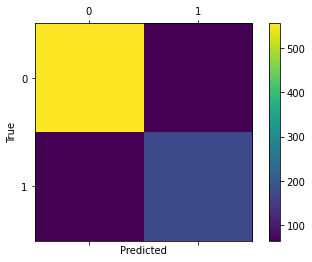

In [51]:
#To test from a saved model, model and tokenizer needs to be fetched from load_model
#To test on a newly trained model comment out the line below (only works if training is done one time in the cells above, not the training loop)
#model, tokenizer = load_model()
predictions, true_labels = test(32, model, tokenizer)
accur, f1 = get_test_accuracy_and_f1_score(predictions, true_labels)
tn, fp, fn, tp = confusion_matrix(true_labels_flattened(true_labels), predictions_flattened(predictions)).ravel()
cm = confusion_matrix(true_labels_flattened(true_labels), predictions_flattened(predictions))
print("  Accuracy: {0:.3f}".format(accur))
print("  f-1 score: {0:.3f}".format(f1))
print('true negative: ' , tn, '\nfalse negative: ', fn, '\ntrue positive: ', tp, '\nfalse positive: ', fp)
#print(cm)
plot_confusion_matrix(true_labels_flattened(true_labels), predictions_flattened(predictions))

[[556  64]
 [ 57 183]]


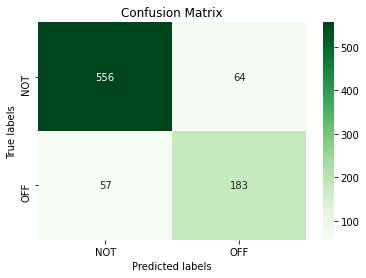

In [36]:
#plot_confusion_matrix(true_labels_flattened(true_labels), predictions_flattened(predictions))
plot_with_heatmap(true_labels_flattened(true_labels), predictions_flattened(predictions))

##Investigate the data set

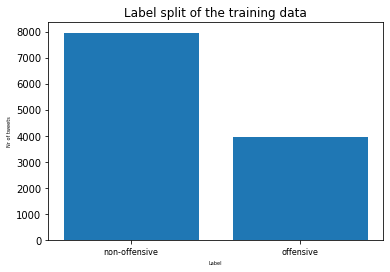

In [ ]:
def count_occurences(labels):
  occurences = []
  OFFcount = np.count_nonzero(labels)
  occurences.append(len(labels)- OFFcount)
  occurences.append(OFFcount)
  return occurences

tweets, labels = get_dataset('90_training_data')
labelStr = ['non-offensive', 'offensive']
occurences = count_occurences(labels)

def plot_data(occurences, labelStr, xlabel, ylabel, title, name):
  fig = plt.figure()
  index = np.arange(len(labelStr))
  plt.bar(index, occurences)
  plt.xlabel(xlabel, fontsize=5)
  plt.ylabel(ylabel, fontsize=5)
  plt.xticks(index, labelStr, fontsize=8)
  plt.title(title)
  plt.show()
  fig.savefig("/content/gdrive/My Drive/thesis/dataset/" + name + ".png")

plot_data(occurences, labelStr, 'Label', 'Nr of tweets', 'Label split of the training data', 'label_split')

Max lenght of tweet:  234


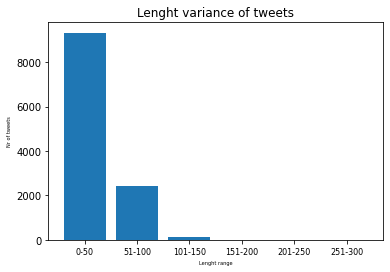

In [ ]:
def get_token_lengths(tweets):
  token_lenghts = []
  for tweet in tweets:
    encoded_tweet = tokenizer(tweet)["input_ids"]
    token_lenghts.append(len(encoded_tweet))
  return token_lenghts

def label_count(counter):
  occurences = [0,0,0,0,0,0]
  for key, value in counter.items():
    if key < 51:
      occurences[0] += value
    elif key > 50 and key < 101:
      occurences[1] += value
    elif key > 100 and key < 151:
      occurences[2] += value
    elif key > 150 and key < 201:
      occurences[3] += value
    elif key > 200 and key < 251:
      occurences[4] += value
    else:
      occurences[5] += value
  return occurences
    
labelStr = ["0-50", "51-100", "101-150", "151-200", "201-250", "251-300"]
token_lenghts = get_token_lengths(tweets)
print("Max lenght of tweet: ", max(token_lenghts))
counter=collections.Counter(token_lenghts)
occurences = label_count(counter)
plot_data(occurences, labelStr, 'Lenght range', 'Nr of tweets', 'Lenght variance of tweets', 'lenght_split')


max_length was set to 150 (+2 for the [CLS] and [SEP] tokens) since the majority of the tweets aren't longer than that. Having a smaller max_len increases the speed of the training.